## Reinforcement Learning

Reinforcement Learning is an area of Machine Learning concerned with how agents ought to take actions in an environment in order to maximize the notion of cumulative reward. Reinforcement Learning is one of the three basic Machine Learning Paradigms, along with Supervised Learning and Unsupervised Learning.

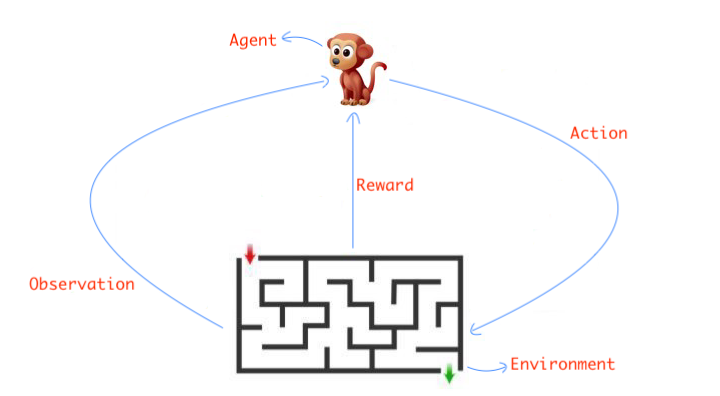

Consider the diagram. This maze represents the "Enivronment" and the dog is the "Agent". Our objective is to teach the agent an optimal policy ("best sequence of actions") so that it can solve the maze. A reward is provided to the agent everytime a right action is taken and a penalty for everytime a wrong action is taken. Each action taken by the agent in the environment results in a new "State".


## Markov Decision Processes

Markov Decision Processes are meant to be a straightforward framing of the problem of learning from interaction to achieve a goal. The learner and decision maker is called the "**Agent**". The thing it interacts with, comprising everything outside the agent, is called the "**Environment**". 

These interact continually, the agent selecting actions and the environment responding to these actions and presenting new situations to the agent. The Environment also gives rise to rewards, special numerical values that the agent seeks to maximize over time through its choice of actions.

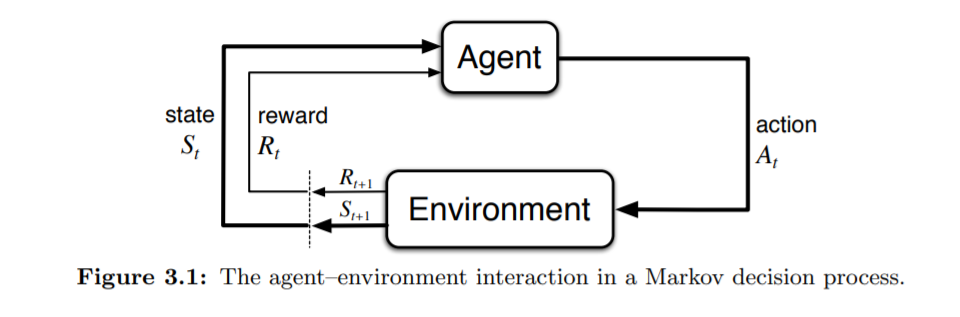

More specifically, the agent and environment interact at each of a sequence of discrete
time steps, t = 0, 1, 2, 3,....
At each time step t, the agent receives some representation
of the environment’s state, St 2 S, and on that basis selects an action, At 2 A(s). 

One time step later, in part as a consequence of its action, the agent receives a numerical
reward, Rt+1 2 R ⇢ R, and finds itself in a new state, St+1. The MDP and agent
together thereby give rise to a sequence or trajectory that begins like this: **S0, A0, R1, S1, A1, R2, S2, A2, R3,...**

We can think of process of receiving a reward as an arbitrary function f that maps the state-action pairs to rewards. At each time t, we have:
                                            **f(St, At) = Rt+1**


## Q Learning

Q-learning is an off policy reinforcement learning algorithm that seeks to find the best action to take given the current state. It’s considered off-policy because the q-learning function learns from actions that are outside the current policy, like taking random actions, and therefore a policy isn’t needed. More specifically, q-learning seeks to learn a policy that maximizes the total reward.

## What's Q in Q Learning?

The 'Q' in q-learning stands for quality. Quality in this case represents how useful a given action is in gaining some future reward.

## Deep Q-Learning

Q-Learning is a simple but a powerful algorithm to teach our agent to extract maximum reward thereby teaching the agent exactly which action to perform.

Consider an environment of 10,000 states and 1,000 actions per state. This would create a table of 10 million cells. The amount of memory required to save and update the table would increase as the number of states increase. The amount of time required to explore each state to create the Q-Table would be unrealistic.

In deep Q-learning, we use a neural network to approximate the Q-value function. The state is given as the input and the Q-value of all possible actions is generated as the output.

The below image gives us an overview of how Q-Learning and Deep-Q-Learning works:

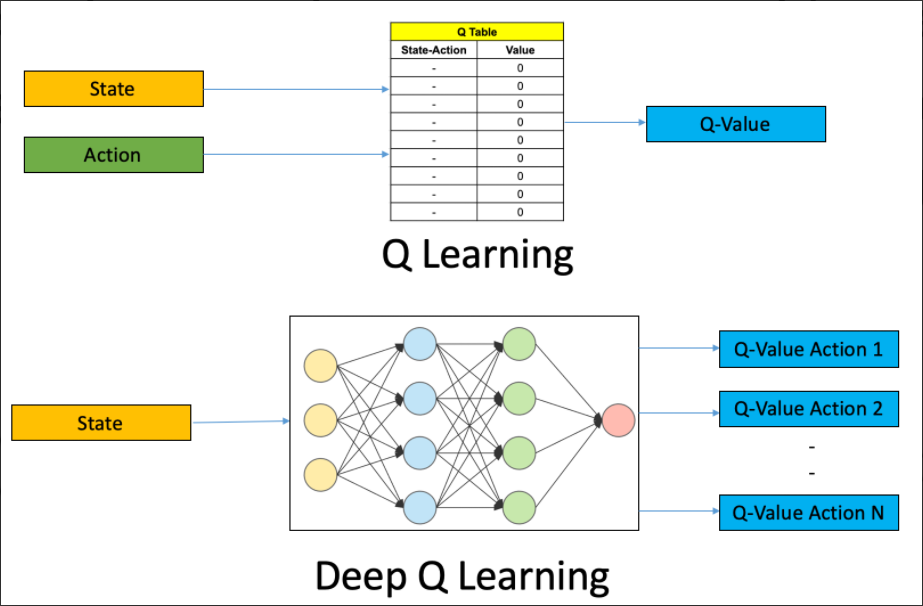

The Steps involved in DQNs are :

1. Preprocess and feed the game screen (state s) to our DQN, which will return the Q-values of all possible actions in thestate
2. Select an action using the epsilon-greedy policy. With the probability epsilon, we select a random action a and with probability 1-epsilon, we select an action that has a maximum Q-value, such as a = argmax(Q(s,a,w))
3. Perform this action in a state s and move to a new state s’ to receive a reward. This state s’ is the preprocessed image of the next game screen. We store this transition in our replay buffer as <s,a,r,s’>
4. Next, sample some random batches of transitions from the replay buffer and calculate the loss
5. It is known that: 
    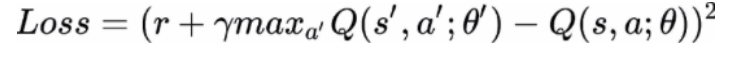

    which is just the squared difference between target Q and predicted Q

6. Perform gradient descent with respect to our actual network parameters in order to minimize this loss
7. After every C iterations, copy our actual network weights to the target network weights
8. Repeat these steps for M number of episodes

Going back to the Q-Value update equation derived from the Bellman equation, we have:

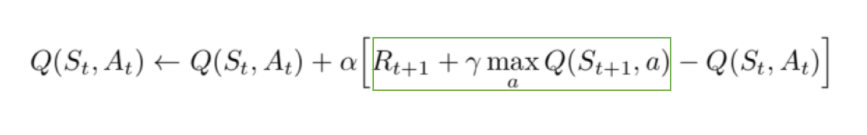

The section in green represents the target. We can argue that it is predicting its own value, but since R is the unbiased true reward, the network is going to update its gradient using backpropogation to finally converge.

## Lunar Lander-v2 Open AI Gym

OpenAI is a toolkit for developing and implementing Reinforcement Learning Algorithms. Here we look to apply DQNs to one of OpenAI's Game Environment Lunar Lander-v2. 

The Objective of the game is to train the agent(Lander) to land in the landing zone indicated between two flags. Since the environment is 2D and since the number of states and available actions in each state is a lot, we look to solve this environment using DQNs. 

The landing pad is always at coordinates (0,0). The coordinates are the first two numbers in the state vector.

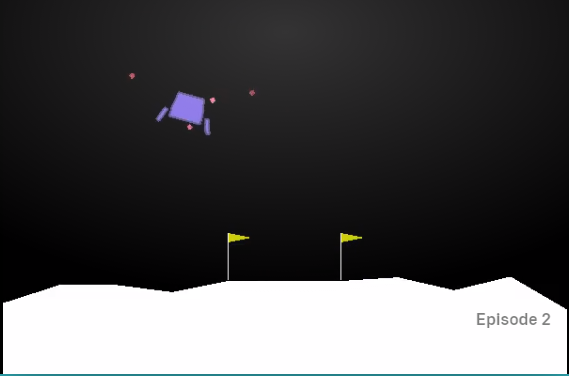

### Discrete Actions

According to Pontryagin's maximum principle it's optimal to fire engine full throttle or turn it off. That's the reason this environment is OK to have discreet actions (engine on or off).

Four Discrete Actions are available: 

1. Do Nothing
2. Fire Left Orientation Engine
3. Fire Right Orientation Engine
4. Fire Main Engine

### Points Scoring

Reward for moving from the top of the screen to the landing pad and zero speed is about 100 to 140 points.
If the lander moves away from the landing pad it loses reward.

Episode: The Episode finishes if the lander crashes or comes to rest, receiving an additional -100 or +100 points.

Everytime the one of the lander's legs makes contact with the ground is an additional 10 points. Firing the main engine is -0.3 points per frame. Firing the side engine is -0.03 points each frame. 

Solved environment is +200 points.

Fuel is infinite so an agent can learn to fly and and then land on its first attempt.




In [2]:
#Importing all Libraries

import gym
import random
from keras import Sequential
from collections import deque
from keras.layers import Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.activations import relu, linear
import numpy as np



Using TensorFlow backend.


In [3]:
#Setting up the Environment

env = gym.make('LunarLander-v2')
env.seed(0)
np.random.seed(0)

In [1]:
##Implementing the Deep Q Learning Algorithm

class DQN:  

   #Initializing the Learning Rate to implement Epsilon-Greedy Policy

    def __init__(self, action_space, state_space):

        self.action_space = action_space
        self.state_space = state_space
        self.epsilon = 1.0
        self.gamma = .99
        self.batch_size = 64
        self.epsilon_min = .01
        self.lr = 0.001
        self.epsilon_decay = .996
        self.memory = deque(maxlen=1000000)
        self.model = self.build_model()

#Building the Neural Network with input layer as the Starting State 
#and Final Layer to be action_Space which determines the end of the episode

    def build_model(self):  

        model = Sequential()
        model.add(Dense(150, input_dim=self.state_space, activation=relu))
        model.add(Dense(120, activation=relu))
        model.add(Dense(self.action_space, activation=linear))
        model.compile(loss='mse', optimizer=Adam(lr=self.lr))
        return model

    #Storing current state, action, reward and next_state in memory 
    def remember(self, state, action, reward, next_state, done): 
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):

        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_space)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self):

        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        states = np.array([i[0] for i in minibatch])
        actions = np.array([i[1] for i in minibatch])
        rewards = np.array([i[2] for i in minibatch])
        next_states = np.array([i[3] for i in minibatch])
        dones = np.array([i[4] for i in minibatch])

        states = np.squeeze(states)
        next_states = np.squeeze(next_states)

        targets = rewards + self.gamma*(np.amax(self.model.predict_on_batch(next_states), axis=1))*(1-dones)
        targets_full = self.model.predict_on_batch(states)
        ind = np.array([i for i in range(self.batch_size)])
        targets_full[[ind], [actions]] = targets

        self.model.fit(states, targets_full, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay




In [2]:
def train_dqn(episode):

    loss = []
    agent = DQN(env.action_space.n, env.observation_space.shape[0])
    for e in range(episode):
        state = env.reset()
        state = np.reshape(state, (1, 8))
        score = 0
        max_steps = 3000
        for i in range(max_steps):
            action = agent.act(state)
            env.render()
            next_state, reward, done, _ = env.step(action)
            score += reward
            next_state = np.reshape(next_state, (1, 8))
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            agent.replay()
            if done:
                print("episode: {}/{}, score: {}".format(e, episode, score))
                break
        loss.append(score)

        # Calculating the Average score of last 100 episodes to see if the cumulative reward score is above 200
        is_solved = np.mean(loss[-100:])
        if is_solved > 200:
            print('\n Task Completed! \n')
            break
        print("Average over last 100 episode: {0:.2f} \n".format(is_solved))
    return loss




Box(-inf, inf, (8,), float32)
Discrete(4)
episode: 0/500, score: -467.9592952121066
Average over last 100 episode: -467.96 

episode: 1/500, score: -269.97945449264193
Average over last 100 episode: -368.97 

episode: 2/500, score: -164.76628672014783
Average over last 100 episode: -300.90 

episode: 3/500, score: -168.73037139905065
Average over last 100 episode: -267.86 

episode: 4/500, score: -357.1159862289321
Average over last 100 episode: -285.71 

episode: 5/500, score: -93.86297422341758
Average over last 100 episode: -253.74 

episode: 6/500, score: -234.46337826082544
Average over last 100 episode: -250.98 

episode: 7/500, score: -373.33667719762775
Average over last 100 episode: -266.28 

episode: 8/500, score: -209.8393380570767
Average over last 100 episode: -260.01 

episode: 9/500, score: -199.2647648907856
Average over last 100 episode: -253.93 

episode: 10/500, score: -145.67306544264596
Average over last 100 episode: -244.09 

episode: 11/500, score: -145.401408964

episode: 97/500, score: -52.218682400074684
Average over last 100 episode: -111.52 

episode: 98/500, score: -1.9449451860831004
Average over last 100 episode: -110.41 

episode: 99/500, score: 66.23164611230254
Average over last 100 episode: -108.65 

episode: 100/500, score: -104.29700491705759
Average over last 100 episode: -105.01 

episode: 101/500, score: -33.771605973337444
Average over last 100 episode: -102.65 

episode: 102/500, score: -59.059071347393804
Average over last 100 episode: -101.59 

episode: 103/500, score: 33.29142046379721
Average over last 100 episode: -99.57 

episode: 104/500, score: 113.51364682861606
Average over last 100 episode: -94.87 

episode: 105/500, score: 22.563847225357787
Average over last 100 episode: -93.70 

episode: 106/500, score: 24.990725990491118
Average over last 100 episode: -91.11 

episode: 107/500, score: 103.50332193642733
Average over last 100 episode: -86.34 

episode: 108/500, score: 110.92825904870611
Average over last 100 epis

episode: 196/500, score: 275.9221255915967
Average over last 100 episode: 161.79 

episode: 197/500, score: 263.85415855730537
Average over last 100 episode: 164.95 

episode: 198/500, score: 272.1581097450502
Average over last 100 episode: 167.69 

episode: 199/500, score: 278.9664376598047
Average over last 100 episode: 169.82 

episode: 200/500, score: 248.06606694937835
Average over last 100 episode: 173.34 

episode: 201/500, score: 248.67386348057425
Average over last 100 episode: 176.17 

episode: 202/500, score: 245.9381092895574
Average over last 100 episode: 179.22 

episode: 203/500, score: 238.21663979232608
Average over last 100 episode: 181.27 

episode: 204/500, score: 286.75941769827307
Average over last 100 episode: 183.00 

episode: 205/500, score: 270.60589481312434
Average over last 100 episode: 185.48 

episode: 206/500, score: 266.54406774668064
Average over last 100 episode: 187.90 

episode: 207/500, score: 146.1671252599666
Average over last 100 episode: 188.32

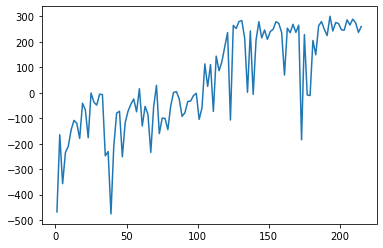

In [6]:
if __name__ == '__main__':

    print(env.observation_space)
    print(env.action_space)
    episodes = 500
    loss = train_dqn(episodes)
    plt.plot([i+1 for i in range(0, len(loss), 2)], loss[::2])
    plt.show()

## Conclusion

We saw how to implement Deep Q Learning when the number of possible states and actions are high where Conventional Q-learning and Q-Table cannot be used. Implemented Deep-Q-Learning using Neural Networks to solve the "Lunar Lander Discrete" environment from OpenAi Gym and observed the Learning rate from the above graph of Total Cumulative Rewards vs Episodes.

## References

1. Medium - https://towardsdatascience.com/solving-lunar-lander-openaigym-reinforcement-learning-785675066197
2. TextBook - Reinforcement Learning: An Introduction by Richard S Sutton and Andrew G. Bartow - http://incompleteideas.net/book/RLbook2020.pdf
3. Youtube - https://www.youtube.com/playlist?list=PLZbbT5o_s2xoWNVdDudn51XM8lOuZ_Njv
4. DeepLizard.com
5. GitHub - https://github.com/shivaverma/OpenAIGym/blob/master/lunar-lander/discrete/lunar_lander.py
6. OpenAI Gym Environment - https://gym.openai.com/envs/LunarLander-v2/
7. Analytics Vidhya - https://www.analyticsvidhya.com/blog/2019/04/introduction-deep-q-learning-python/
8. Stack OverFlow

## LICENSE

Copyright <2020> Keshav K L

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.